# 一、半监督分类器
#### 首先导入运行模型需要的所有模块和库，指定输入图像的大小、噪声向量z的大小以及半监督分类的真实类别的数量（判别器将学习识别每个数字对应的类）

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (
    Activation, BatchNormalization, Concatenate, Dense,
    Dropout, Flatten, Input, Lambda, Reshape
)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam 

from tensorflow.keras import backend as K

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#模型输入维度
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)#输入图像的维度

z_dim = 100#噪声向量的大小

num_classes = 10#数据集中类别的数量

# 1.数据集

仅取一小部分标签

In [2]:
class Dataset:
    def __init__(self, num_labeled):
        self.num_labeled = num_labeled#训练集中使用的有标签图像的数量
        
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()
        
        def preprocess_imgs(x):
            x = (x.astype(np.float32) - 127.5) / 127.5#灰度像素值从[0, 255]缩放到[-1, 1]
            x = np.expand_dims(x, axis=3)#将图像尺寸扩展到宽x高x通道数
            return x
        
        def preprocess_labels(y):
            return y.reshape(-1, 1)#将元素转换成一列
        
        #训练
        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)
        #测试
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)
        
    def batch_labeled(self, batch_size):
            #获取随机批量的有标签图像及其标签
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels
        
    def batch_unlabeled(self, batch_size):
        #获取随机批量的无标签图像
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0], batch_size)
        imgs = self.x_train[idx]
        return imgs
        
    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train
        
    def test_set(self):
        return self.x_test, self.y_test

num_labeled = 100#要使用的有标签样本的数量（其余作为无标签样本使用）

dataset = Dataset(num_labeled)


# 2.生成器

In [3]:
def build_generator(z_dim):
    model = Sequential()
    
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, 3, 2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, 3, 2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(1, 3, 1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, 7, padding='same'))
    model.add(Activation('tanh'))
    return model 


# 3.判别器

### 3.1 判别器目标
（1）区分真实样本和伪样本。为此，SGAN判别器使用了sigmoid函数，输出用于二元分类的概率。

（2）对于真实样本，还要对其标签准确分类。为此，SGAN判别器使用了softmax函数，输出概率向量——每个目标类别对应一个。

### 3.2核心判别器

SGAN判别器模型与DCGAN中实现的基于ConvNet的判别器相似。实际上，直到3×3×128卷积层，它的批归一化和LeakyReLU激活与之前的一直是完全相同的。

在该层之后添加了一个Dropout，这是一种正则化技术，通过在训练过程中随机丢弃神经元及其与网络的连接来防止过拟合。这就迫使剩余的神经元减少它们之间的相互依赖，并得到对基础数据更一般的表示形式。随机丢弃的神经元比例由比例参数指定，在本实现中将其设置为0.5，即mode1.add(Dropout(0.5))。由于SGAN分类任务的复杂性增加，我们使用了Dropout，以提高模型从只有100个有标签的样本中归纳的能力。

In [4]:
def build_discriminator_net(img_shape):
    model = Sequential()
 
    model.add(Conv2D(128,kernel_size=3,strides=2,input_shape=img_shape,padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128,kernel_size=3,strides=2,input_shape=img_shape,padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128,kernel_size=3,strides=2,input_shape=img_shape,padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(num_classes))
    return model


注意，Dropout层是在批归一化之后添加的。出于这两种技不之间的相互作用，这种方法已显示出优越的性能。

另外，请注意前面的网络以一个具有10个神经元的全连接层结束，接下来，我们需要定义从这些神经元计算出的两个判别器输出：一个用于有监督的多分类(使用softmax)，另一个用于无监督的二分类(使用sigmoid)。

### 3.2有监督的判别器

In [5]:
def build_discriminator_supervised(discriminator_net):
    model = Sequential()
    
    model.add(discriminator_net)
    model.add(Activation('softmax'))
    return model


### 3.3无监督的判别器
predict(x)这个函数将10个神经元（来自核心判别器网络）的输出转换成一个二分类的真假预测。

In [6]:
def build_discriminator_unsupervised(discriminator_net):
    model = Sequential()
    
    model.add(discriminator_net)
    def predict(x):
        prediction = 1.0 - (1.0 / (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))#将真实类别的分布转换为二元真-假率
        return prediction
    model.add(Lambda(predict))#之前定义的真假输出元
    
    return model


# 4.搭建模型
注意，有监督损失和无监督损失分别使用categorical_crossentropy和binary_crossentropy损失函数。

In [7]:
def build_sgan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    return model
discriminator_net = build_discriminator_net(img_shape)#核心判别器网络：这些层在有监督和无监督训练中共享

#构建并编译有监督训练判别器
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer=Adam(lr=0.0002, beta_1=0.5)
)

#构建并编译无监督训练判别器
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.0002, beta_1=0.5)
)

#构建生成器
generator = build_generator(z_dim)
discriminator_unsupervised.trainable = False#生成器训练时，判别器参数保持不变

#构建并编译判别器固定的GAN模型，以训练生成器（判别器使用无监督版本）
sgan = build_sgan(generator, discriminator_unsupervised)
sgan.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.0002, beta_1=0.5)
)


# 5.训练

### 算法

对每次训练选代，执行以下操作。

训练判别器（有监督）。

随机取小批量有标签的真实样本(x, y)

计算给定小批量的D((x, y))并反向传播多分类损失更新θ(D)，以使损失最小化。

训练判别器（无监督）。

随机取小批量无标签的真实样本x。

计算给定小批量的D(x)并反向传播二元分类损失更新θ(D)，以使损失最小化。

随机取小批量的随机噪声z生成一小批量伪样本：G(z)=x∗。

计算给定小批量的D(x∗)并反向传播二元分类损失更新θ(D)以使损失最小化。

训练生成器。

随机取小批量的随机噪声z生成一小批量伪样本：G(z)=x∗。

计算给定小批量的D(x∗)并反向传播二元分类损失更新θ(G)以使损失最大化。

结束

In [8]:
supervised_losses = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    real = np.ones((batch_size, 1))#真实图像的标签：全为1
    fake = np.zeros((batch_size, 1))#伪图像的标签：全为0
    
    for iteration in range(iterations):
    
        imgs, labels = dataset.batch_labeled(batch_size)#获取有标签样本
        labels = to_categorical(labels, num_classes=num_classes)#独热编码标签
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)#获取无标签样本
        
        #生成一批伪图像
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)
        #训练有标签的真实样本
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)
        
        #训练无标签的真实样本
        d_loss_real = discriminator_unsupervised.train_on_batch(imgs_unlabeled, real)
        
        #训练伪样本
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)
        
        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        #生成一批伪样本
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)
        
        #训练生成器
        g_loss = sgan.train_on_batch(z, np.ones((batch_size, 1)))
        
        if(iteration + 1) % sample_interval == 0:
            #保存判别器的有监督分类损失，以便绘制损失曲线
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)
            
            print("%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]" 
                  % (iteration + 1, d_loss_supervised, 100 * accuracy, d_loss_unsupervised, g_loss))
            sample_image(generator)#输出生成图像的采样


### 5.1生成图像

In [9]:
def sample_image(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, 100))#随机噪声采样
    
    gen_imgs = generator.predict(z)#从随机噪声生成图像
    
    gen_imgs = 0.5 * gen_imgs + 0.5#图像缩放到[0, 1]：[-1, 1]--->[0, 1]
    
    fig, axs = plt.subplots(
        image_grid_rows,
        image_grid_columns,
        figsize=(4, 4),
        sharex=True, 
        sharey=True
    )
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1


### 5.2训练模型
之所以使用较小的批量，是因为只有100个有标签的训练样本。我们通过反复试验确定迭代次数：不断增加次数，直到判别器的有监督损失趋于平稳，但不要超过稳定点太远（以降低过拟合的风险）。

2000 [D loss supervised: 0.0020, acc.: 100.00%] [D loss unsupervised: 0.4950] [G loss: 1.372798]
4000 [D loss supervised: 0.0010, acc.: 100.00%] [D loss unsupervised: 0.5695] [G loss: 1.682728]
6000 [D loss supervised: 0.0014, acc.: 100.00%] [D loss unsupervised: 0.3490] [G loss: 2.225100]
8000 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.5358] [G loss: 1.898516]
10000 [D loss supervised: 0.0003, acc.: 100.00%] [D loss unsupervised: 0.3608] [G loss: 2.218489]
12000 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.4197] [G loss: 2.404803]
14000 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.3123] [G loss: 1.843764]
16000 [D loss supervised: 0.0002, acc.: 100.00%] [D loss unsupervised: 0.3252] [G loss: 2.175725]
18000 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.4184] [G loss: 2.329590]
20000 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.5284] [G loss: 1.940744]


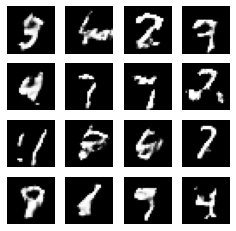

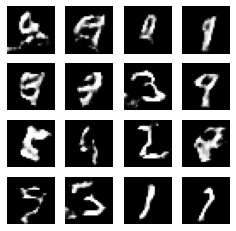

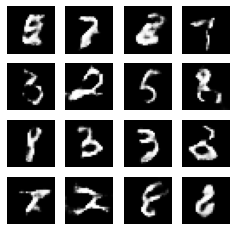

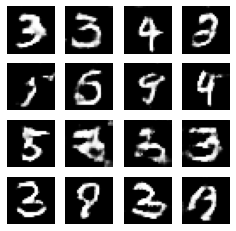

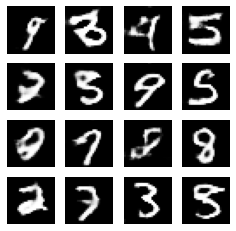

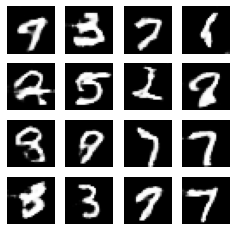

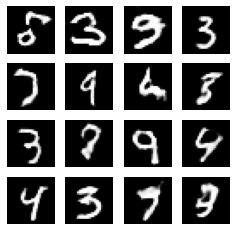

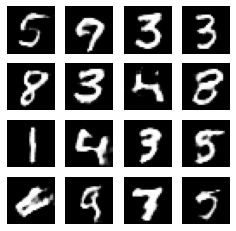

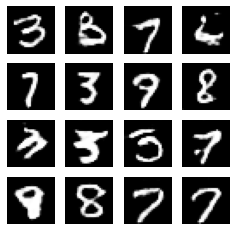

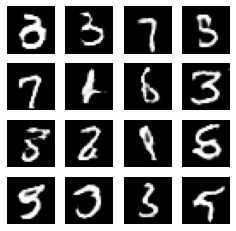

In [10]:
iterations = 20000
batch_size = 32
sample_interval = 2000

train(iterations, batch_size, sample_interval)


### 5.3模型训练和测试准确率
在训练过程中，SGAN达到了100%的有监督准确率。尽管这看似很好，但请记住只有100个有标签的样本用于有监督训练——也许模型只是记住了训练数据集。分类器能在多大程度上泛化到训练集中未见过的数据上才是重要的。

In [11]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

_, acc = discriminator_supervised.evaluate(x, y)
print('Test accuracy: %.2f%%' % (100 * acc))


313/313 [==============================] - 2s 7ms/step - loss: 0.1803 - accuracy: 0.9438
Test accuracy: 94.38%


# 二、与全监督分类器的对比
为了使比较尽可能公平，我们让全监督分类器使用与训练有监督判别器相同的网络结构。这样做的意图在于，这将能突显出半监督学习GAN对分类器泛化能力的提提高。

Epoch 1/30
4/4 [==============================] - 0s 19ms/step - loss: 2.2993 - acc: 0.0909
Epoch 2/30
4/4 [==============================] - 0s 18ms/step - loss: 2.2473 - acc: 0.2613
Epoch 3/30
4/4 [==============================] - 0s 19ms/step - loss: 2.2088 - acc: 0.3284
Epoch 4/30
4/4 [==============================] - 0s 19ms/step - loss: 2.1640 - acc: 0.4015
Epoch 5/30
4/4 [==============================] - 0s 20ms/step - loss: 2.0999 - acc: 0.3985
Epoch 6/30
4/4 [==============================] - 0s 19ms/step - loss: 1.9894 - acc: 0.4819
Epoch 7/30
4/4 [==============================] - 0s 19ms/step - loss: 1.8981 - acc: 0.6018
Epoch 8/30
4/4 [==============================] - 0s 19ms/step - loss: 1.8177 - acc: 0.5982
Epoch 9/30
4/4 [==============================] - 0s 19ms/step - loss: 1.7126 - acc: 0.5742
Epoch 10/30
4/4 [==============================] - 0s 19ms/step - loss: 1.5223 - acc: 0.7422
Epoch 11/30
4/4 [==============================] - 0s 20ms/step - loss: 1.3460 

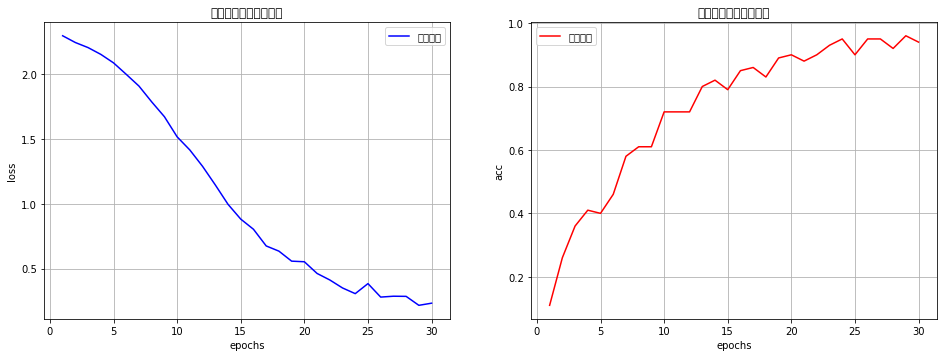

In [16]:
#有着与SGAN判别器相同网络结构的全监督分类器
mnist_classifier = build_discriminator_supervised(
    build_discriminator_net(img_shape)
)

mnist_classifier.compile(
    loss='categorical_crossentropy',
    metrics=['acc'],
    optimizer=Adam(lr=0.0002, beta_1=0.5)
)

imgs, labels = dataset.training_set()

labels = to_categorical(labels, num_classes=num_classes)

history = mnist_classifier.fit(
    imgs,
    labels,
    batch_size=batch_size,
    epochs=30
)

train_result = history.history

trian_loss = train_result['loss']
train_acc = train_result['acc']
epochs = range(1, len(trian_loss) + 1)

plt.figure(figsize=(16, 12))

plt.subplot(221)
plt.grid()
plt.title('全监督分类器训练损失')
plt.plot(epochs, trian_loss, 'b', label='训练损失')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')

plt.subplot(222)
plt.grid()
plt.title('全监督分类器训练精度')
plt.plot(epochs, train_acc, 'r', label='训练精度')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend(loc='best')


In [17]:
mnist_classifier.evaluate(x, y)


313/313 [==============================] - 2s 7ms/step - loss: 1.0430 - acc: 0.6850


[1.0430171489715576, 0.6850000023841858]

与SGAN的判别器一样，全监督分类器在训练数据集上达到了接近100%的准确率。但是在测试集上它只能正确分类大约70%的样本，比SGAN差了约20个百分点。换句话说，SGAN将训练准确率提高了近30个百分点！

随着训练数据的增加，全监督分类器的泛化能力显著提高。使用相同的设置和训练，使用10000个有标签样本(是最初使用样本的100倍)训练的全监督分类器，可以达到约98%的准确率，不过这不是半监督学习。

# 三、小结

我们通过教判别器输出真实样本的类别标签，来探索如何把GAN用于半监督学习。可以看到，经过SGAN训练的分类器从少量训练样本中泛化的能力明显优于全监督分类器。从GAN创新的角度来看，SGAN的主要特点是在判别器训练中使用标签，你可能想知道标签是否也可以用于生成器训练，条件GAN应用而生。

#### 1.半监督生成对抗网络(SGAN)的判别器可用来：区分真实样本与伪样本；给真实样本分配正确的类别标签。
#### 2.SGAN的目的是将判别器训练成一个分类器，使之可以从尽可能少的有标签样本中获得更高的分类精度，从而减少分类任务对大量标注数据的依赖性。
#### 3.我们将softmax和多元交叉熵损失用于分配真实标签的有监督任务，将sigmoid和二元交叉熵用于区分真实样本和伪样本。
#### 4.我们证明了SGAN对没见过的测试集数据的分类准确率远远优于在相同数量的有标签样本上训练的全监督分类器。